In [47]:
# Import libraries

# Basic
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.feature_selection import RFECV, SelectKBest
from sklearn.ensemble import GradientBoostingRegressor


# My own cleaning libraryb
import cleaning_tools as ct
import tools

# For reloading my tools, while working on them
from importlib import reload

import warnings
warnings.filterwarnings('ignore')

seed = 42

In [48]:
for c in num_cols:
    print(c)

Lot_Frontage
Lot_Area
Overall_Qual
Overall_Cond
Year_Built
Year_Remod/Add
Mas_Vnr_Area
BsmtFin_SF_1
BsmtFin_SF_2
Bsmt_Unf_SF
Low_Qual_Fin_SF
Gr_Liv_Area
Bsmt_Full_Bath
Bsmt_Half_Bath
Full_Bath
Half_Bath
Bedroom_AbvGr
Kitchen_AbvGr
TotRms_AbvGrd
Fireplaces
Garage_Yr_Blt
Garage_Area
Wood_Deck_SF
Misc_Val
Mo_Sold
Yr_Sold
Total_SF
porch_area
Overall_Qual2
Heating_QC
Kitchen_Qual
Exter_Qual
Exter_Cond
Bsmt_Qual
Bsmt_Cond
Fireplace_Qu
Garage_Qual
Garage_Cond
Pool_QC
Central_Air
Garage_Finish


In [132]:
# Load Training Data
data = tools.load_data('../data/train.csv')

def clean(data):
    # Transform columns
    data['Total_SF']      = data['Total_Bsmt_SF'] + data['1st_Flr_SF'] + data['2nd_Flr_SF']
    data['porch_area']    = data['Open_Porch_SF'] + data['Enclosed_Porch'] + data['3Ssn_Porch'] + data['Screen_Porch']
    data['Overall_Qual2'] = data['Overall_Qual']**2
    data['Year_Built2']   = data['Year_Built']**2

    data.drop(['Total_Bsmt_SF', '1st_Flr_SF', '2nd_Flr_SF'], axis=1, inplace=True)
    data.drop('Garage_Cars', axis=1, inplace=True)
    data.drop('Pool_Area',   axis=1, inplace=True)
    data.drop('MS_SubClass', axis=1, inplace=True)
    data.drop('Kitchen_AbvGr', axis=1, inplace=True)
    data.drop(['Id', 'PID'], axis=1, inplace=True)
    
    # Map to number
    data = ct.map_to_number(data)
    
    return data

data = clean(data)

# Outliers :
data = data[data['Lot_Frontage'] < 250].copy()
data = data[data['Lot_Area'] < 20000]



# Split X/y
y = data[['SalePrice']].copy()
X = data.drop('SalePrice', axis=1)
X.drop(['Open_Porch_SF', 'Enclosed_Porch', '3Ssn_Porch', 'Screen_Porch'], axis=1, inplace=True)

# Add
num_cols = [c for c in X.columns if X[c].dtype in [np.int64, np.float64]]
str_cols = [c for c in X.columns if X[c].dtype not in [np.int64, np.float64]]
X = X[num_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

imputer = Imputer(strategy='median').fit(X_train)
X_train = imputer.transform(X_train)
X_test  = imputer.transform(X_test)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)


In [94]:
X.shape

(1689, 39)

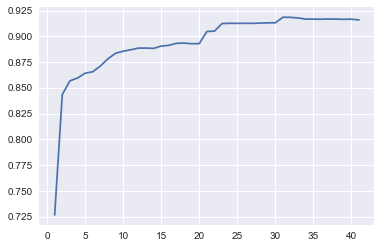

In [133]:
R = Ridge(alpha=0.8)
scores = []
ks = [i for i in range(1, X_train.shape[1]+1)]
for k in ks:
    _ = SelectKBest(k=k).fit_transform(X_train, y_train)
    cvs = cross_val_score(R, _, y_train, cv=3)
    scores.append(cvs.mean())
    
plt.plot(ks, scores)

best alpha :  0.6
mean score :  0.908514388002


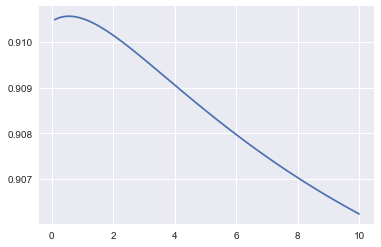

In [130]:
scores = []
alpha = np.linspace(0.1, 10, num=100)
for a in alpha:
    R = Ridge(alpha=a)
    cvs = cross_val_score(R, X_train, y_train, cv=3)
    scores.append(cvs.mean())

plt.plot(alpha, scores)
print('best alpha : ', alpha[scores.index(max(scores))])
print('mean score : ', np.mean(scores))

In [135]:
R = Ridge(alpha=0.6)
R.fit(X_train, y_train)
print(R.score(X_train, y_train))
print(R.score(X_test, y_test))

0.924677161002
0.900755276342


In [124]:
data_test = tools.load_data('../data/test.csv')
ids       = data_test[['Id']].copy()
data_test = clean(data_test)

X_final = data_test[num_cols]
X_final = imputer.transform(X_final)
X_final = scaler.transform(X_final)
y_final = pd.DataFrame(R.predict(X_final), columns=['SalePrice'])

final_df = pd.concat([ids, y_final], axis=1)
final_df.to_csv('sub4_polys.csv', index=False)

In [125]:
X_final.shape

(879, 41)